## 4-blobs classifier

In [186]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Getting the data

In [187]:
from sklearn.datasets import make_blobs

n_samples = 1000
X, y = make_blobs(n_samples, centers=4, n_features=2, random_state=104)

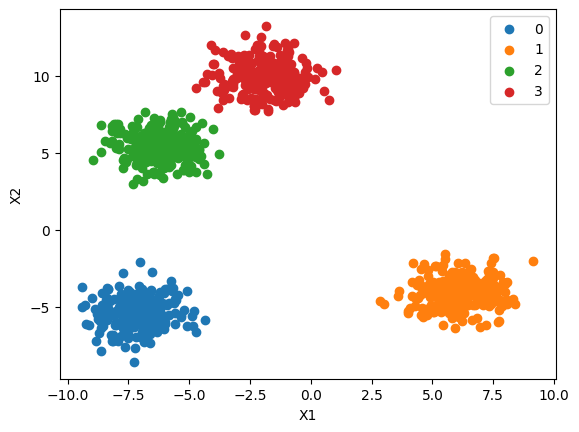

In [188]:
for i in np.unique(y):
    plt.scatter(X[np.where(y==i), 0], X[np.where(y==i), 1], label=i)
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.show()

In [189]:
# Checking the shapes
X.shape, y.shape

((1000, 2), (1000,))

### Selecting the device and convertion data into tensors

In [190]:
import torch
from torch import nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [191]:
X, y = torch.from_numpy(X).type(torch.float).to(device=device), torch.from_numpy(y).type(torch.LongTensor).to(device=device)

X[:5], y[:5]

(tensor([[-1.3151,  8.9351],
         [-2.7065,  9.7321],
         [ 5.7924, -4.4601],
         [-3.1961,  9.2996],
         [ 4.6968, -4.0488]], device='cuda:0'),
 tensor([3, 3, 1, 3, 1], device='cuda:0'))

In [192]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=10)

In [193]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [194]:
class BlobsClassifierV0(nn.Module):
    def __init__(self, in_features, out_features, hidden_units):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=out_features),
        )
    
    def forward(self, x):
        return self.layers(x)

In [195]:
blobs_4_model = BlobsClassifierV0(in_features=2, out_features=4, hidden_units=6).to(device=device)
blobs_4_model

BlobsClassifierV0(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=6, bias=True)
    (1): Linear(in_features=6, out_features=4, bias=True)
  )
)

In [196]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(blobs_4_model.parameters(), lr=0.01)

In [197]:
blobs_4_model(X_train)[0].shape, 4 # Check if we have the same number of output predictions that we need

(torch.Size([4]), 4)

In [198]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    accuracy = (correct / len(y_pred)) * 100
    return accuracy

In [199]:
torch.manual_seed(10)

epochs = 1000
logs = []

for epoch in range(epochs):
    blobs_4_model.train()

    y_logits = blobs_4_model(X_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_train)
    accuracy = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.inference_mode():
        test_logits = blobs_4_model(X_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_test)
        test_accuracy = accuracy_fn(y_test, test_preds)
    
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}\nTrain loss: {loss:.5f}\nTrain accuracy: {accuracy:.2f}%\nTest loss: {test_loss:.5f}\nTest accuracy: {test_accuracy:.2f}%', end='\n\n')
    logs.append({
        'epoch': epoch,
        'train_loss': loss,
        'test_loss': test_loss,
        'train_accuracy': accuracy,
        'test_accuracy': test_accuracy
    })

Epoch: 0
Train loss: 0.97179
Train accuracy: 74.25%
Test loss: 0.81236
Test accuracy: 78.00%

Epoch: 10
Train loss: 0.44408
Train accuracy: 99.75%
Test loss: 0.41936
Test accuracy: 100.00%

Epoch: 20
Train loss: 0.33038
Train accuracy: 99.62%
Test loss: 0.31988
Test accuracy: 100.00%

Epoch: 30
Train loss: 0.26951
Train accuracy: 99.75%
Test loss: 0.26192
Test accuracy: 100.00%

Epoch: 40
Train loss: 0.22785
Train accuracy: 99.75%
Test loss: 0.22147
Test accuracy: 100.00%

Epoch: 50
Train loss: 0.19699
Train accuracy: 99.88%
Test loss: 0.19135
Test accuracy: 100.00%

Epoch: 60
Train loss: 0.17310
Train accuracy: 100.00%
Test loss: 0.16800
Test accuracy: 100.00%

Epoch: 70
Train loss: 0.15405
Train accuracy: 100.00%
Test loss: 0.14938
Test accuracy: 100.00%

Epoch: 80
Train loss: 0.13855
Train accuracy: 100.00%
Test loss: 0.13421
Test accuracy: 100.00%

Epoch: 90
Train loss: 0.12570
Train accuracy: 100.00%
Test loss: 0.12164
Test accuracy: 100.00%

Epoch: 100
Train loss: 0.11491
Train a

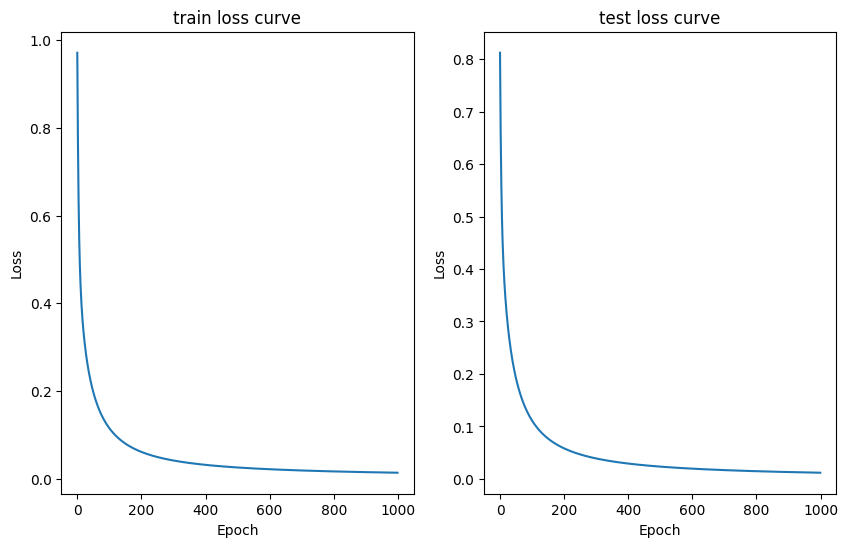

In [200]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
for i, type in enumerate(['train', 'test']):
    ax[i].set_title(f'{type} loss curve')
    ax[i].plot(range(epochs), [log.get(f'{type}_loss').item() for log in logs])
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Loss')

In [201]:
print(f"The final accuracy is: {logs[-1].get('test_accuracy')}%")

The final accuracy is: 100.0%
